In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import cv2


# Data Cleaning

In [2]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv/haarcascade_eye.xml')

def face_crop(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:    
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        if len(eyes) >= 2:
            return roi_color
   

In [14]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [6]:
import os
img_dirs = []

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)     
        
img_dirs

['./dataset/cropped',
 './dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

In [26]:
import shutil

if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [27]:
cropped_img_dirs = []

for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    count = 1
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = face_crop(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name

            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("Generationg cropped images in the folder : ", cropped_folder)
            
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generationg cropped images in the folder :  ./dataset/cropped/lionel_messi
Generationg cropped images in the folder :  ./dataset/cropped/maria_sharapova
Generationg cropped images in the folder :  ./dataset/cropped/roger_federer
Generationg cropped images in the folder :  ./dataset/cropped/serena_williams
Generationg cropped images in the folder :  ./dataset/cropped/virat_kohli


In [15]:
import os

cropped_img_dir = []

for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        cropped_img_dir.append(entry.path)

celebrity_file_names_dict = {}

for img_dir in cropped_img_dir:
    celeb = img_dir.split('/')[-1]
    celebrity_file_names_dict[celeb] = []
    for entry in os.scandir(img_dir):
        celebrity_file_names_dict[celeb].append(entry.path)
        

# Feature Engineering

In [16]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img 
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    
    imArray = np.float32(imArray)
    imArray /= 255
    
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

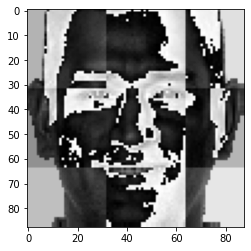

In [17]:
im_har = w2d(face_crop('test/dhoni.png'), 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [18]:
celeb_map = {}
count = 0

for celeb, files in celebrity_file_names_dict.items():
    celeb_map[celeb] = count
    count += 1
    
celeb_map

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [19]:
X = []
y = []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    print(celebrity_name)
    for file in training_files:
        img = cv2.imread(file)
    
            
        scalled_raw = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        
        combined_img = np.vstack((scalled_raw.reshape((32*32*3, 1)), scalled_img_har.reshape((32*32, 1))))
        X.append(combined_img)
        y.append(celeb_map[celebrity_name])

lionel_messi
maria_sharapova
roger_federer
serena_williams
virat_kohli


In [20]:
X = np.array(X).reshape(len(X), 4096).astype(float)
print(X.shape)
y = np.array(y)
y.shape

(167, 4096)


(167,)

# Model Training

In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='linear', C=10))])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7857142857142857

In [23]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.75      1.00      0.86         6
           2       0.50      0.67      0.57         6
           3       0.80      0.50      0.62         8
           4       0.90      0.90      0.90        10

    accuracy                           0.79        42
   macro avg       0.77      0.78      0.76        42
weighted avg       0.80      0.79      0.78        42



In [24]:
params = {
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params': {
            'svc__kernel': ['linear', 'rbf', 'poly'],
            'svc__C': [0.1, 1, 10, 100]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
        'logisticregression__solver': ['newton-cg',  'liblinear'],
        'logisticregression__C': [0.1, 1, 10]
        }
    },
    'random_forest_classifier': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_leaf_nodes': [40, 60]
        }
    }
    
}

In [25]:
from sklearn.model_selection import GridSearchCV

scores = []
best_estimators = {}

for model_name, model in params.items():
    pipe = make_pipeline(StandardScaler(), model['model'])
    clf = GridSearchCV(pipe , model['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
    best_estimators[model_name] = clf.best_estimator_

In [26]:
scores

[{'model': 'svm',
  'best_score': 0.8560000000000001,
  'best_params': {'svc__C': 0.1, 'svc__kernel': 'linear'}},
 {'model': 'logistic_regression',
  'best_score': 0.8560000000000001,
  'best_params': {'logisticregression__C': 0.1,
   'logisticregression__solver': 'liblinear'}},
 {'model': 'random_forest_classifier',
  'best_score': 0.8320000000000001,
  'best_params': {'randomforestclassifier__criterion': 'gini',
   'randomforestclassifier__max_leaf_nodes': 40}}]

In [27]:
import pandas as pd
df = pd.DataFrame(scores)
df.head()

,model,best_score,best_params
0,svm,0.856,"{'svc__C': 0.1, 'svc__kernel': 'linear'}"
1,logistic_regression,0.856,"{'logisticregression__C': 0.1, 'logisticregres..."
2,random_forest_classifier,0.832,"{'randomforestclassifier__criterion': 'gini', ..."


In [28]:
clf = best_estimators['svm']
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7857142857142857

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, clf.predict(X_test))
cm

array([[10,  0,  0,  1,  1],
       [ 0,  6,  0,  0,  0],
       [ 1,  1,  4,  0,  0],
       [ 0,  1,  3,  4,  0],
       [ 0,  0,  1,  0,  9]], dtype=int64)

Text(69.0, 0.5, 'Truth')

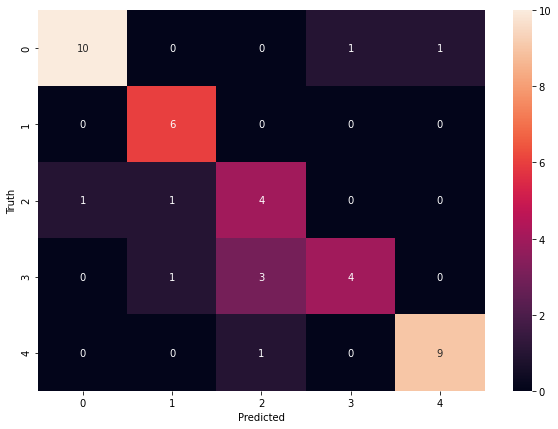

In [30]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel('Truth')

In [31]:
celeb_map

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

# Model Saving

In [32]:
import joblib

joblib.dump(clf, 'final_model.pkl')

['final_model.pkl']

In [33]:
import json

with open("class_dictionary.json", "w") as f:
    json.dump(celeb_map, f)